## Abstract

In this project we trained different state-of-the-art (SOTA) object detection models for the task of pothole detection and evaluated their performance under  self-synthesized motion blur noise. This noise was generated using randomized kernel types and sizes to simulate real-world conditions where camera shake or motion artifacts may degrade image quality. The study provides insights into how motion blur affects detection accuracy and offers recommendations for improving the robustness of automated road maintenance systems.

Moreover, we created our own dataset where we classified the potholes into three severity levels: `low`, `medium`, and `high`. This classification was based on how dangerous a pothole is to cars and pedestrians, which can help prioritize road maintenance efforts and allocate resources more effectively. The dataset was annotated with bounding boxes and severity labels, enabling the models to learn to detect and classify potholes simultaneously.

## Project Goals



- Train and evaluate different object detection models for pothole detection.
- Investigate the impact of motion blur on detection accuracy.
- Create a pothole dataset with severity labels for classifing potholes danger levels.

## Imports

In [2]:
import utils
import data_process
import trainer
import evaluator
import motion_blur

## Dataset
We used the following dataset from kaggle [chitholian_annotated_potholes_dataset](https://www.kaggle.com/datasets/chitholian/annotated-potholes-dataset)

The Dataset contains 665 images of potholes on roads with corresponding annotations boxes for each pothole.

We created a custom torch dataset named PotholeDetectionDataset and then split them to seperate train, validation and test sets (70-10-20).

In [ ]:
!python3 data_process.py

Data already exists

Number of valid images: 664
Train set size: 464 - 69.88%
Validation set size: 67 - 10.09%
Test set size: 133 - 20.03%



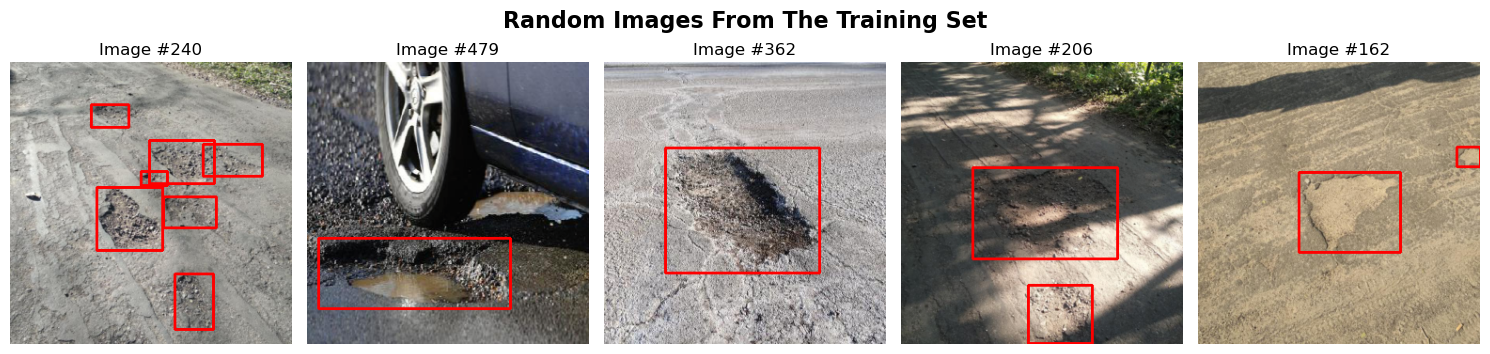

In [2]:
data_process.display_images_from_trainset()

## Object Detection Models

we compared between the following models:
* yolov8
* faster rcnn
* ssd
* fcos
* retinanet

we have used hyperparameters tuning with optuna to find the best hyperparameters for each model.
you can find the hyperparameters we checked in the main README file.
and the code can be found under `trainer.py` file.

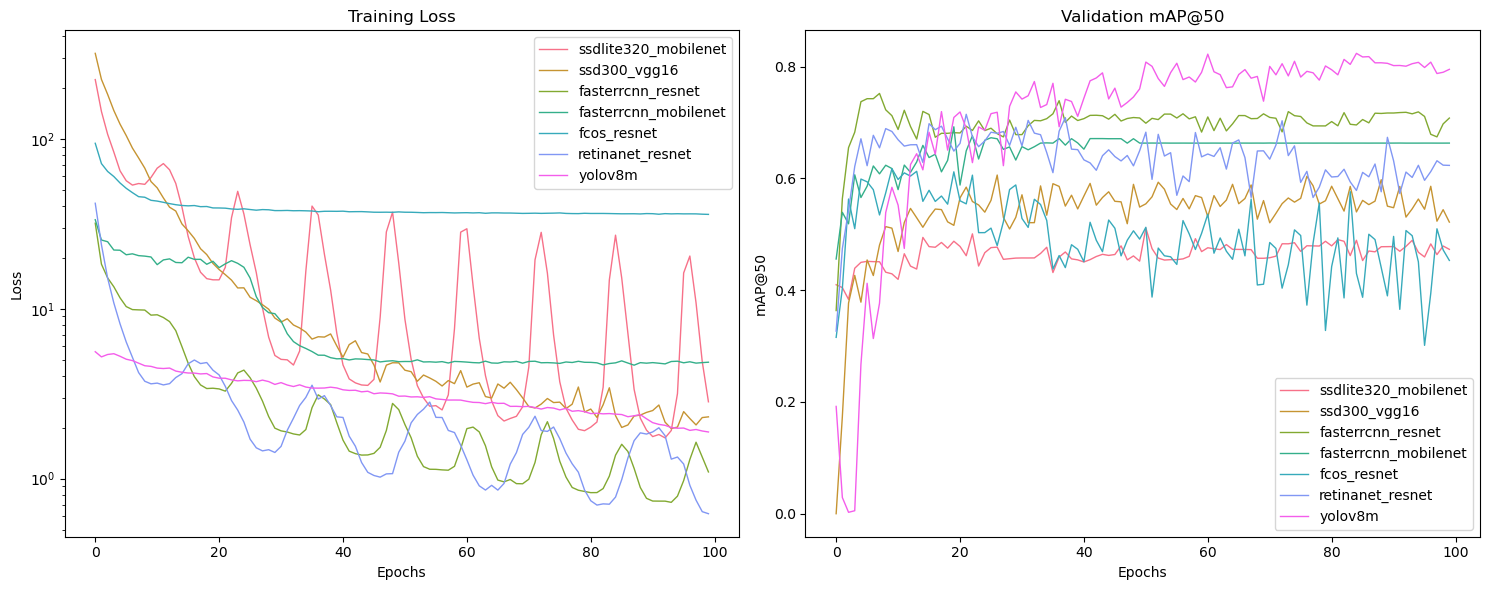

In [9]:
utils.plot_loss_and_map()

In [3]:
utils.display_results_table(with_augmentations=False)

,Model Name,fps,Train Time (seconds),Model Parameters,Model Size (MB),test mAP@50
0,ssdlite320_mobilenet,565.13,471.12,"2,402,360",9.27,40.9%
1,ssd300_vgg16,279.29,523.71,"23,707,188",90.58,51.83%
2,fasterrcnn_resnet,56.43,2240.47,"41,076,761",157.95,70.06%
3,fasterrcnn_mobilenet,229.41,675.25,"18,871,333",72.40,55.74%
4,fcos_resnet,60.37,2043.92,"31,842,055",122.72,54.24%
5,retinanet_resnet,67.16,2100.74,"36,127,286",138.88,61.88%
6,yolov8m,192.31,632.45,"25,856,899",98.76,73.85%


The results highlight distinct trade-offs between model efficiency, complexity, and accuracy.   

- yolov8m offers the best accuracy (73.85%) with a reasonable FPS (192.31) and moderate model size (98.76 MB), making it a strong choice for tasks requiring both speed and precision.
- In contrast, ssdlite320_mobilenet excels in real-time applications with the highest FPS (565.13) and smallest size (9.27 MB) but achieves a modest test mAP@50 of 40.9%. 
- fasterrcnn_resnet and retinanet_resnet exhibit high complexity with large parameter counts and model sizes, trading off speed for respectable accuracies of 70.06% and 61.88%, respectively. 


## Motion Blur Noise

<div style="text-align: center;">
    <img src="./data/motion_blur_data/motion_blur_types.png" style="height: 500px;">
</div>

## Suggested Data Augmentations

To cope with the motion blur noise, we applied the following data augmentations using [kornia](https://kornia.readthedocs.io/en/latest/):

| **Augmentation**       | **Parameters**                                                                 | **Description**                                                                 |
|------------------------|---------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| `RandomMotionBlur`     | `kernel_size=(3, 51)`, `angle=(-180.0, 180.0)`, `direction=(-1.0, 1.0)`, `p=0.4` | Apply random motion blur.                                                      |
| `RandomGaussianBlur`   | `kernel_size=(3, 3)`, `sigma=(0.1, 2.0)`, `p=0.3`                               | Apply random Gaussian blur to simulate out-of-focus blur.                      |
| `RandomSharpness`      | `sharpness=(0.5, 2.0)`, `p=0.3`                                                 | Adjust the sharpness of the image to simulate varying levels of focus.         |
| `ColorJiggle`          | `brightness=0.2`, `contrast=0.2`, `saturation=0.2`, `p=0.2`                      | Apply a random transformation to the brightness, contrast, saturation, and hue.|

## Models performance after data augmentation
Here are the results for the models we evaluated after applying data augmentation.
We evaluted the models on the test set and also applied different kinds of motion blur noise to the images.

You can checked detailed results for each model under the `models_evaluation_with_noise` folder.

### Clean (No Noise)

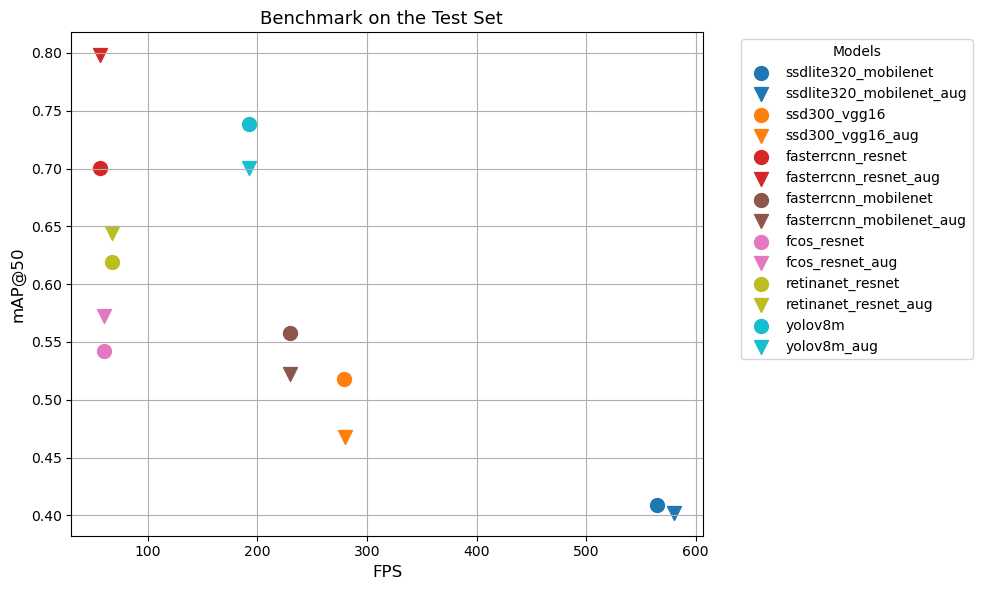

In [4]:
utils.plot_test_results(show_augmentations=True)

### results on fasterrcnn resnet before and after data augmentations

you can see for example for image #545 that was a FP prediction of a car as a pothole, but in general all GT potholes were detected.

<img src="./data/plots/fasterrcnn_resnet/fasterrcnn_resnet_test.png">

<img src="./data/plots/fasterrcnn_resnet_aug/fasterrcnn_resnet_test_aug.png">

## Synthesized Motion Blur

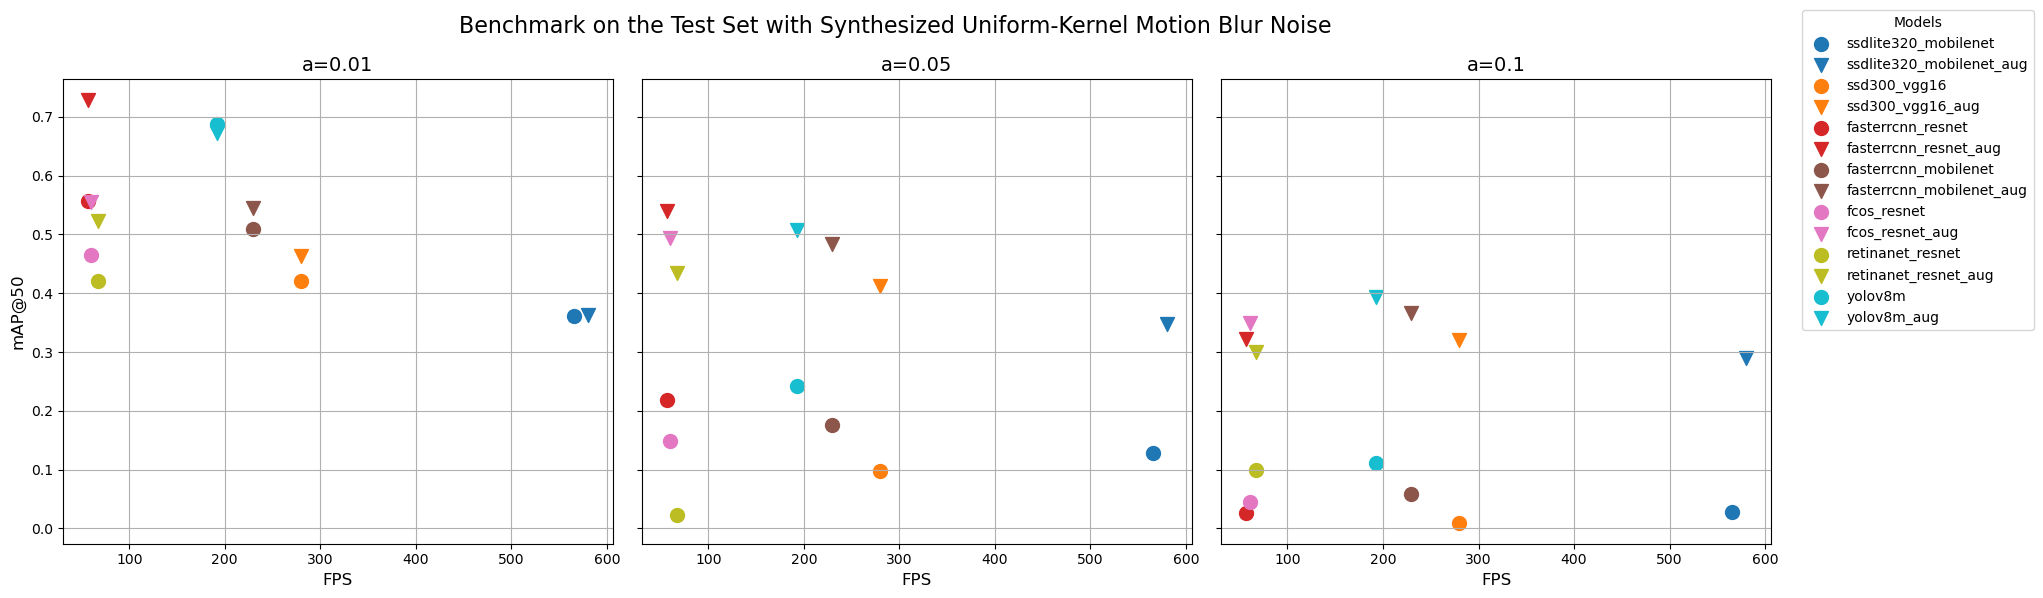

In [8]:
utils.plot_test_results(show_augmentations=True, noise_type='uni')

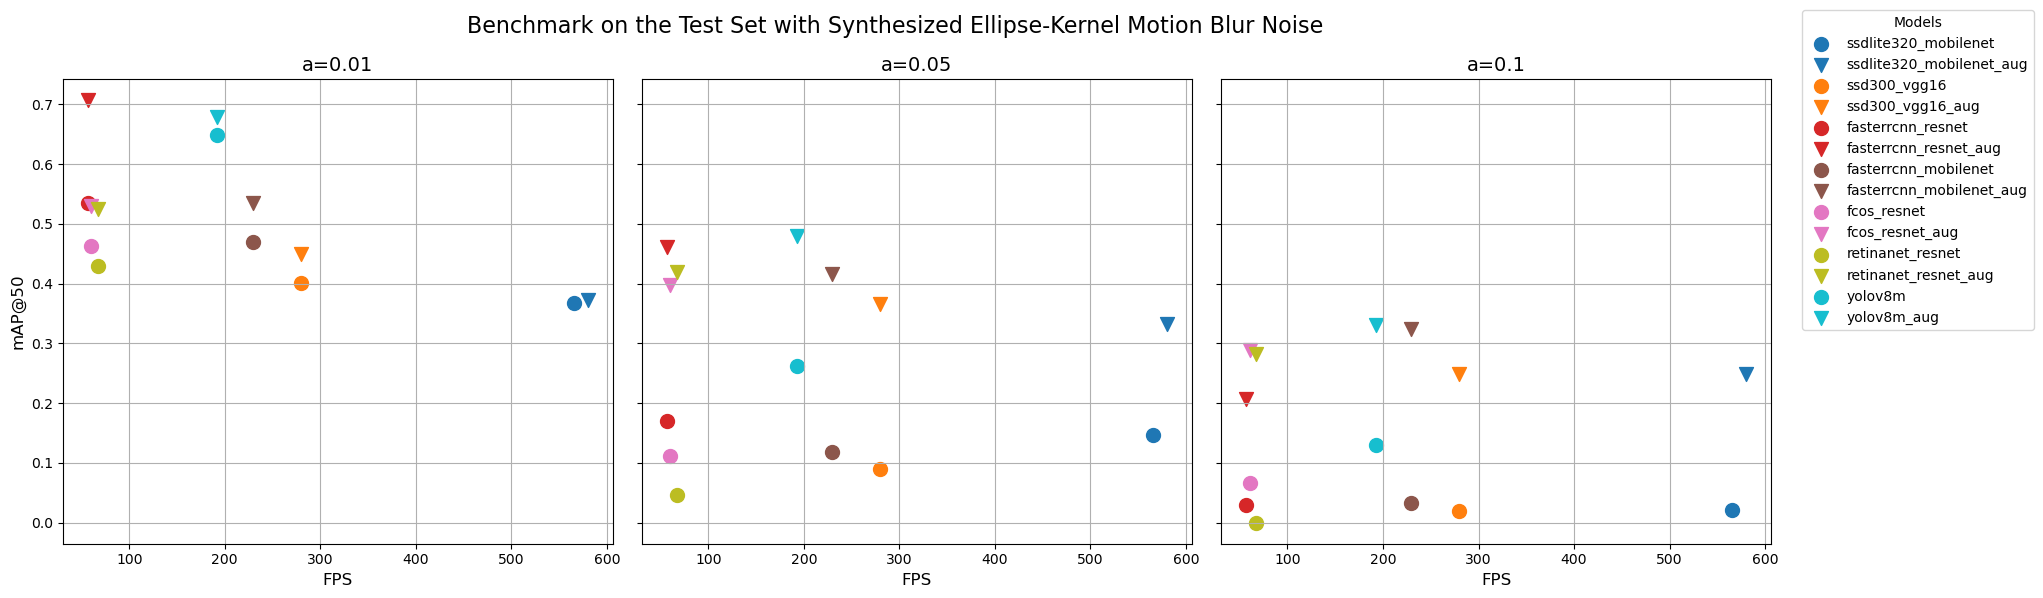

In [9]:
utils.plot_test_results(show_augmentations=True, noise_type='eli')

### results on fasterrcnn resnet before and after data augmentations
In this example we can see how data augmentation helped the model to detect the potholes even with motion blur noise. However it comes with the cost of more false positives.
<div align=center>
<img src="./data/plots/faster_rcnn_eli_comparison.png">
</div>

In [12]:
utils.display_results_table(with_augmentations=True)

,Model Name,fps,Train Time (seconds),Model Parameters,Model Size (MB),test clean mAP@50,test uniform 0.01 mAP@50,test uniform 0.05 mAP@50,test uniform 0.1 mAP@50,test ellipse 0.01 mAP@50,test ellipse 0.05 mAP@50,test ellipse 0.1 mAP@50,test natural mAP@50
0,ssdlite320_mobilenet,565.13,471.12,"2,402,360",9.27,40.9%,36.06%,12.86%,2.77%,36.8%,14.66%,2.17%,31.2%
1,ssdlite320_mobilenet_aug,580.24,481.70,"2,402,360",9.27,40.23%,36.35%,34.73%,29.0%,37.21%,33.15%,24.85%,38.61%
2,ssd300_vgg16,279.29,523.71,"23,707,188",90.58,51.83%,42.13%,9.8%,0.99%,40.06%,8.92%,1.99%,18.77%
3,ssd300_vgg16_aug,279.60,537.66,"23,707,188",90.58,46.81%,46.36%,41.2%,32.12%,44.94%,36.61%,24.93%,38.83%
4,fasterrcnn_resnet,56.43,2240.47,"41,076,761",157.95,70.06%,55.67%,21.89%,2.65%,53.55%,17.0%,2.97%,46.55%
5,fasterrcnn_resnet_aug,56.43,2240.47,"41,076,761",157.95,79.8%,72.79%,53.98%,32.16%,70.65%,46.09%,20.73%,61.42%
6,fasterrcnn_mobilenet,229.41,675.25,"18,871,333",72.40,55.74%,50.88%,17.58%,5.79%,47.03%,11.88%,3.24%,35.72%
7,fasterrcnn_mobilenet_aug,229.41,675.25,"18,871,333",72.40,52.24%,54.51%,48.4%,36.61%,53.52%,41.58%,32.42%,54.4%
8,fcos_resnet,60.37,2043.92,"31,842,055",122.72,54.24%,46.42%,14.86%,4.48%,46.25%,11.22%,6.57%,37.71%
9,fcos_resnet_aug,60.37,2043.92,"31,842,055",122.72,57.26%,55.52%,49.35%,34.89%,52.91%,39.81%,28.94%,47.41%


## Pothole Severity

To revise the dataset we add severity tags to it and we trained the models on the new dataset.
Each pothole is now classified into one of three severity levels: `low`, `medium`, and `high`. 
This classification was based on how dangerous a pothole is to cars and pedestrians, which can help prioritize road maintenance efforts and allocate resources more effectively.

we decided to train only the best models we found on the previous section on the new dataset.
`yolov8` and `faster rcnn resnet` models.

you can also check further results under `models_evaluation_with_severity_levels.ipynb`

In [14]:
# download the new dataset
!python3 data_process.py --with_severity_levels True 

Data already was processed



## Results
As you can see below the faster rcnn resnet model failed on the new dataset, while the yolov8 model performed quite decent on the new dataset achived a mAP@50 of 0.49.

The improved performance of YOLOv8 on the updated dataset is likely due to its efficient one-stage design, which handles complex class distinctions better by directly predicting object locations and classifications. Dividing potholes by severity increased dataset complexity, where YOLOv8's anchor-free architecture and robust feature extraction proved more adaptable. In contrast, fasterrcnn_resnet, a two-stage detector, relies on precise region proposals and anchor configurations, making it less suited for fine-grained class variations, leading to its poor performance.

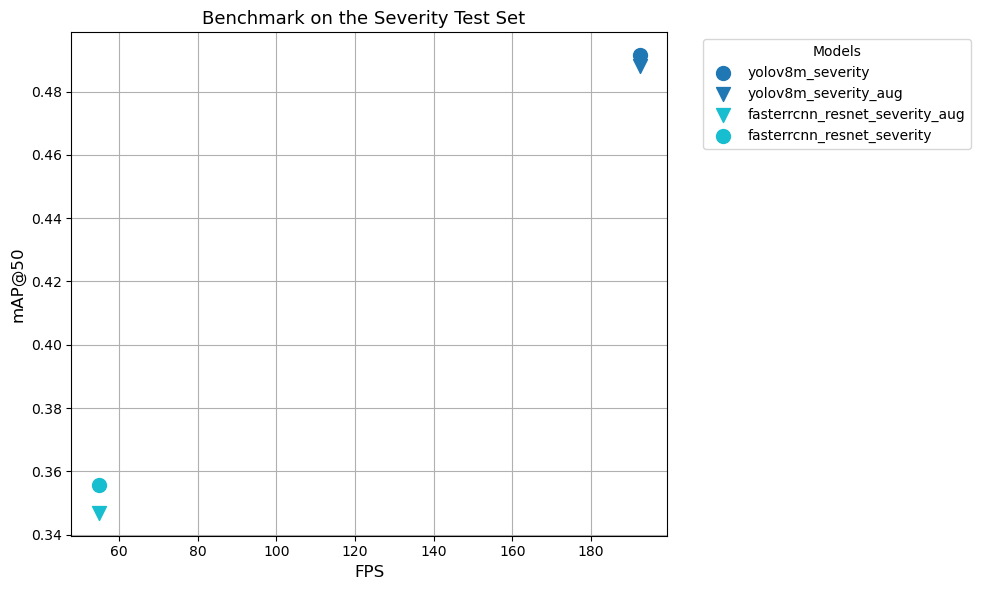

In [19]:
utils.plot_test_results(noise_type=None, show_augmentations=True, show_severity=True)

#### yolov8m inference video for example
<div style="text-align: center;">
    <img src="./data/readme/yolo_video.gif" style="height: 200px;">
</div>

In [22]:
utils.display_results_table(with_augmentations=True, with_severity=True)

,Model Name,fps,Train Time (seconds),Model Parameters,Model Size (MB),test clean mAP@50,test uniform 0.01 mAP@50,test uniform 0.05 mAP@50,test uniform 0.1 mAP@50,test ellipse 0.01 mAP@50,test ellipse 0.05 mAP@50,test ellipse 0.1 mAP@50,test natural mAP@50
0,yolov8m_severity,192.31,663.86,"25,858,057",98.77,49.15%,45.44%,19.6%,7.91%,47.5%,19.2%,9.48%,35.77%
1,yolov8m_severity_aug,192.31,663.81,"25,858,057",98.77,48.79%,46.0%,34.87%,25.63%,43.96%,31.83%,21.76%,36.94%
2,fasterrcnn_resnet_severity_aug,54.82,2359.93,"41,087,011",157.99,34.69%,34.29%,31.67%,24.06%,36.77%,28.8%,18.5%,33.7%
3,fasterrcnn_resnet_severity,54.96,2326.27,"41,087,011",157.99,35.56%,22.59%,9.56%,0.7%,24.79%,7.81%,1.75%,19.86%
